## Simple Linear Regression Introduction

In this notebook, we go over Linear Regression methods to predict the __log_votes__ field of our Amazon Product Review dataset. 

1. <a href="#1">Read the dataset</a>
2. <a href="#2">Exploratory Data Analysis</a>
3. <a href="#3">Select features to build the model</a>
4. <a href="#4">Data processing using Bag of Words</a>
5. <a href="#5">Train a regressor</a>

*Find more details on the classical Linear Regression models [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model).*

__Amazon Product Review Dataset__:

In this exercise, we are working with a product review dataset from Amazon. The raw data is available [here](https://nijianmo.github.io/amazon/index.html). You can find this dataset under `DATA/product-reviews`: Amazon_Reviews_Regression.csv and Amazon_Reviews_Classification.csv.

__Dataset schema:__ 
* __reviewText__ - Text of the review
* __summary__ - Summary of the review
* __verified__ - Whether the purchase was verified (True or False)
* __time__ - UNIX timestamp for the review
* __rating__ - Rating of the review
* __log_votes__ - Logarithm-adjusted votes log(1+votes). This field is a processed version of the votes field. People can click on the "helpful" button when they find a customer review helpful. This increases the vote by 1. This formulation helps us get a smaller range for votes. This is the field to predict.


## 1. Read the dataset
(<a href="#0">Go to top</a>)

We will use the Pandas library to read our dataset.

In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved
# SPDX-License-Identifier: MIT-0

import pandas as pd

df = pd.read_csv('../../DATA/product-reviews/Amazon_Reviews_Regression.csv')

print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (55000, 6)


Let's look at the first five rows in the dataset. As you can see the __log_votes__ field is numeric. That's why we will build a regression model.

In [2]:
df.head()

reviewText  \
0  Stuck with this at work, slow and we still got...   
1  I use parallels every day with both my persona...   
2  Barbara Robbins\n\nI've used TurboTax to do ou...   
3  I have been using this software security for y...   
4  If you want your computer hijacked and slowed ...   

                                             summary  verified        time  \
0                                  Use SEP or Mcafee     False  1464739200   
1                                       Use it daily     False  1332892800   
2                                    Helpful Product      True  1398816000   
3                                         Five Stars      True  1430784000   
4  ... hijacked and slowed to a crawl Windows 10 ...     False  1508025600   

   rating  log_votes  
0     1.0        0.0  
1     5.0        0.0  
2     4.0        0.0  
3     5.0        0.0  
4     1.0        0.0

## 2. Exploratory Data Analysis
(<a href="#0">Go to top</a>)

Let's look at the distribtion of the only numerical feature in the dataset (`rating`).

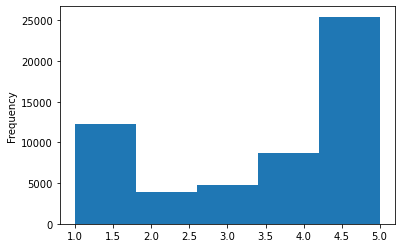

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
df['rating'].plot.hist(bins=5)
plt.show()

Let's look at the distribution of the categorical column in the dataset (`verified`).

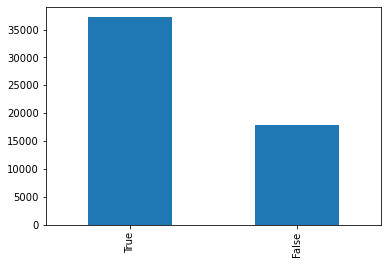

In [4]:
df['verified'].value_counts().plot.bar()
plt.show()

#### Target distribution

Let's check our target: Let's look at the range and distribution of log_votes.

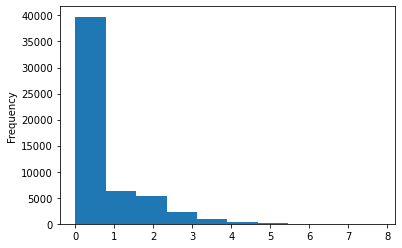

In [5]:
df['log_votes'].plot.hist(bins=10)
plt.show()

In [6]:
df["log_votes"].min()

0.0

In [7]:
df["log_votes"].max()

7.799753318287247

#### Missing values
We can check the number of missing values for each columm below.

In [8]:
print(df.isna().sum())

reviewText    6
summary       7
verified      0
time          0
rating        0
log_votes     0
dtype: int64


### Imputation
Let's fill-in the missing values for __reviewText__ below. We will just use the placeholder "Missing" here. We will focus on the __reviewText__ column and drop the __summary__ column later, so there is no need to fill the missing values for __summary__.

In [9]:
df["reviewText"].fillna("Missing", inplace=True)

## 3. Selecting features to build the model
(<a href="#0">Go to top</a>)

In this particular dataset, there are 2 text based columns which we want to prepare to use and 1 categorical and 1 numerical column each. For now, we ignore the __time__ column and as mentioned previously we also drop __summary__.

In [10]:
df.drop('time', axis = 1, inplace = True)
df.drop('summary', axis = 1, inplace = True)

#### Cleaning text features 

Text cleaning can be performed here, before train/test split, with less code. The cleaning should happen after stop words have been removed as there will be fewer words to process.

In [11]:
# Install the library and functions
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will create the stop word removal and text cleaning processes below. NLTK library provides a list of common stop words. We will use the list, but remove some of the words from that list (because those words are actually useful to understand the sentiment in the sentence).

In [12]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
    
    return final_text_list

In [13]:
df["reviewText"] = process_text(df["reviewText"].tolist()) 

In [14]:
df['verified'] = df['verified'].astype(str)

## 4. Data processing using Bag of Words (BoW)
(<a href="#0">Go to top</a>)

We are using binary features here. TF and TF-IDF are other options.

In [15]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_scaler', MinMaxScaler()) 
                                ])
                  
# Preprocess the categorical features
categorical_processor = Pipeline([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')) 
                                ])
# Preprocess 1st text feature
text_processor = Pipeline([
    ('text_vect', CountVectorizer(binary=False, max_features=250))
                                ])


# Combine all data preprocessors from above
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, ['rating']),
    ('categorical_pre', categorical_processor, ['verified']),
    ('text_pre', text_processor, ['reviewText'][0]),
                                    ]) 

## 5. Train a regressor
(<a href="#0">Go to top</a>)

Let's first fit __LinearRegression__ from Sklearn library. Using the __coef___ atribute, we can also print the learned weights of the model. Find more details [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [16]:
from sklearn import set_config
set_config(display='diagram')

X_train, y_train = df[["reviewText", "rating", "verified"]], df["log_votes"].tolist()

from sklearn.linear_model import LinearRegression

### PIPELINE ###
################

lr_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('lrRegressor', LinearRegression())
                    ])

In [17]:
# Train the model
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['rating']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verified']),
                                                 ('text_pre',
                                                  Pipeline(steps=[('text_vect',
                                                                   CountVectorizer(max_features=250))]),
                                                  'reviewText')])),
                ('lrRegressor', LinearRegression())])

In [18]:
print("LinearRegression model weights: \n", lr_pipeline[-1].coef_)

LinearRegression model weights: 
 [-3.95041692e-01  2.06687497e-01 -2.06687497e-01  3.17627205e-03
 -4.22059476e-02 -1.84109285e-02  1.02595615e-02 -1.76075484e-03
  2.70965394e-02 -6.87998027e-02  2.46542167e-02 -1.15603661e-03
  3.46413653e-03 -4.78237898e-02  4.01413193e-02  1.40875370e-02
 -3.79374523e-02  1.88880643e-02 -1.82463519e-02 -1.86716543e-02
 -2.44772593e-02  3.33349902e-02  4.64531598e-02  3.26568252e-02
 -3.66085368e-02  2.10067979e-03  8.53176194e-03  5.67341271e-02
  3.57042444e-02  5.57432678e-03  3.32622264e-02  1.58690556e-04
  5.61102273e-02  5.13750300e-02 -2.29505656e-02  6.48524629e-03
  6.87372395e-02  2.19757300e-02  7.88786995e-02 -5.83749097e-03
  1.66661389e-02  1.47325482e-02  2.74522004e-02 -3.31769592e-02
  3.20551229e-02  6.42461211e-02  2.98817880e-02  9.87860391e-04
  2.81014376e-02  7.50636113e-02 -4.27624359e-03  1.91179737e-02
 -1.47065564e-02  7.04921121e-03 -5.56341596e-03  2.39759447e-03
  3.88324006e-02  3.05572417e-02 -7.43054950e-03  2.2829

In [19]:
from sklearn.linear_model import Lasso

### PIPELINE ###
################

l_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('ridgeRegressor', Lasso(alpha = 0.001))
                    ])

In [20]:
# Train the model
l_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['rating']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verified']),
                                                 ('text_pre',
                                                  Pipeline(steps=[('text_vect',
                                                                   CountVectorizer(max_features=250))]),
                                                  'reviewText')])),
                ('ridgeRegressor', Lasso(alpha=0.001))])